#Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='djamo-data')
pd.set_option('display.max_columns', None)

#Extraction des données RFM 90 jour

In [ ]:
# ===========================================
# Extraction des données RFM 90 jours - Djamo Fintech
# ===========================================

query = """
WITH snapshot_date_cte AS (
    SELECT DATE('2025-09-17') AS snapshot_date
),

eligible_clients AS (
    SELECT DISTINCT clientId AS clientid
    FROM `djamo-data.production_civ_djamo.public_account`
    WHERE DATE(createdAt) <= DATE_SUB((SELECT snapshot_date FROM snapshot_date_cte), INTERVAL 90 DAY)
),

active_clients_90d AS (
    SELECT DISTINCT clientid
    FROM `djamo-data.marts_growth.int_monthly_active_users`
    WHERE DATE(issueddate) BETWEEN DATE_SUB((SELECT snapshot_date FROM snapshot_date_cte), INTERVAL 90 DAY)
                               AND (SELECT snapshot_date FROM snapshot_date_cte)
      AND amount != 0
),

active_client AS (
    SELECT DISTINCT e.clientid
    FROM eligible_clients e
    INNER JOIN active_clients_90d a USING (clientid)
),

last_txn AS (
    SELECT
        m.clientid,
        DATE_DIFF((SELECT snapshot_date FROM snapshot_date_cte), MAX(DATE(m.issueddate)), DAY) AS days_since_last_transaction
    FROM `djamo-data.marts_growth.int_monthly_active_users` m
    WHERE DATE(m.issueddate) <= (SELECT snapshot_date FROM snapshot_date_cte)
      AND m.clientid IN (SELECT clientid FROM active_client)
    GROUP BY m.clientid
),

txn_90d AS (
    SELECT
        m.clientid,
        COUNT(*) AS txn_count_90d,
        COUNT(DISTINCT DATE(m.issueddate)) AS active_days_count_90d,
        SUM(ABS(m.amount)) AS total_txn_volume_90d,
        AVG(ABS(m.amount)) AS avg_total_txn_volume_90d,
        STDDEV_POP(ABS(m.amount)) AS value_consistency_std
    FROM `djamo-data.marts_growth.int_monthly_active_users` m
    WHERE DATE(m.issueddate) BETWEEN DATE_SUB((SELECT snapshot_date FROM snapshot_date_cte), INTERVAL 90 DAY)
                               AND (SELECT snapshot_date FROM snapshot_date_cte)
      AND m.clientid IN (SELECT clientid FROM active_client)
    GROUP BY m.clientid
),

current_balance_snapshot AS (
    WITH ranked_balances AS (
        SELECT
            clientid,
            balance,
            updatedAt,
            ROW_NUMBER() OVER (PARTITION BY clientid ORDER BY updatedAt DESC) as rn
        FROM `djamo-data.production_civ_djamo.public_account`
        WHERE category = "primary"
          AND DATE(updatedAt) <= (SELECT snapshot_date FROM snapshot_date_cte)
          AND clientid IN (SELECT clientid FROM active_client)
    )
    SELECT clientid, balance AS current_account_balance_snapshot
    FROM ranked_balances
    WHERE rn = 1
),

vault_balance_snapshot AS (
    WITH ranked_vault_balances AS (
        SELECT
            clientid,
            balance,
            updatedAt,
            ROW_NUMBER() OVER (PARTITION BY clientid ORDER BY updatedAt DESC) as rn
        FROM `djamo-data.production_civ_djamo.public_account`
        WHERE category = "vault"
          AND DATE(updatedAt) <= (SELECT snapshot_date FROM snapshot_date_cte)
          AND clientid IN (SELECT clientid FROM active_client)
    )
    SELECT clientid, balance AS vault_balance_snapshot
    FROM ranked_vault_balances
    WHERE rn = 1
),

aum_snapshot AS (
    SELECT
        acc.clientId AS clientid,
        SUM(CAST(s.amount AS FLOAT64)) AS aum_snapshot
    FROM `djamo-data.production_civ_djamo.nsia_invest_account` acc
    JOIN `djamo-data.production_civ_djamo.nsia_invest_subscription` s
      ON acc.id = s.accountId
    WHERE acc.isActive = TRUE
      AND acc.deletedAt IS NULL
      AND s.status = 'validated'
      AND acc.clientId IN (SELECT clientid FROM active_client)
      AND DATE(s.updatedAt) <= (SELECT snapshot_date FROM snapshot_date_cte)
    GROUP BY acc.clientId
),

has_vault AS (
    SELECT DISTINCT clientid, 1 AS has_vault
    FROM `djamo-data.production_civ_djamo.public_account`
    WHERE category = "vault"
      AND clientid IN (SELECT clientid FROM active_client)
),

has_invest AS (
    SELECT DISTINCT clientId AS clientid, 1 AS has_invest
    FROM `djamo-data.production_civ_djamo.nsia_invest_account`
    WHERE isActive = TRUE
      AND deletedAt IS NULL
      AND clientId IN (SELECT clientid FROM active_client)
)

SELECT
    ac.clientid,
    (SELECT snapshot_date FROM snapshot_date_cte) AS snapshot_date,
    COALESCE(l.days_since_last_transaction, 90) AS days_since_last_transaction,  -- première feature
    COALESCE(t.txn_count_90d, 0) AS txn_count_90d,
    COALESCE(t.total_txn_volume_90d, 0) AS total_txn_volume_90d,
    COALESCE(t.active_days_count_90d, 0) AS active_days_count_90d,
    1 + COALESCE(vh.has_vault, 0) + COALESCE(ih.has_invest, 0) AS nb_active_products,
    COALESCE(t.value_consistency_std, 0) AS value_consistency_std,
    SAFE_DIVIDE(COALESCE(t.txn_count_90d, 0), GREATEST(COALESCE(t.active_days_count_90d, 0), 1)) AS txn_frequency_ratio,
    COALESCE(t.avg_total_txn_volume_90d, 0) AS avg_total_txn_volume_90d,
    COALESCE(cb.current_account_balance_snapshot, 0) AS current_account_balance,
    COALESCE(vb.vault_balance_snapshot, 0) AS vault_balance,
    COALESCE(a.aum_snapshot, 0) AS aum_snapshot,
    COALESCE(cb.current_account_balance_snapshot, 0) +
    COALESCE(vb.vault_balance_snapshot, 0) +
    COALESCE(a.aum_snapshot, 0) AS total_assets_snapshot,
    SAFE_DIVIDE(COALESCE(t.total_txn_volume_90d, 0), GREATEST(COALESCE(cb.current_account_balance_snapshot, 0), 1)) AS balance_velocity_90d
FROM active_client ac
LEFT JOIN txn_90d t ON ac.clientid = t.clientid
LEFT JOIN last_txn l ON ac.clientid = l.clientid
LEFT JOIN current_balance_snapshot cb ON ac.clientid = cb.clientid
LEFT JOIN vault_balance_snapshot vb ON ac.clientid = vb.clientid
LEFT JOIN aum_snapshot a ON ac.clientid = a.clientid
LEFT JOIN has_vault vh ON ac.clientid = vh.clientid
LEFT JOIN has_invest ih ON ac.clientid = ih.clientid
ORDER BY txn_count_90d DESC
"""

# Exécution de la requête
df_rfm_90d = client.query(query).to_dataframe()
print(df_rfm_90d.shape)
df_rfm_90d.head()


(262781, 15)


,clientid,snapshot_date,days_since_last_transaction,txn_count_90d,total_txn_volume_90d,active_days_count_90d,nb_active_products,value_consistency_std,txn_frequency_ratio,avg_total_txn_volume_90d,current_account_balance,vault_balance,aum_snapshot,total_assets_snapshot,balance_velocity_90d
0,87cede5e-ba5b-40a2-bd49-1e47e3c00022,2025-09-17,0,4745,52347697.64,74,2,22969.289991,64.121622,11032.180746,1035.00,0.0,0.0,1035.00,5.057749e+04
1,f1f73e5d-6d0a-466f-8429-dc9fa364d8dd,2025-09-17,0,2889,13772599.54,90,2,6559.354329,32.100000,4767.254946,0.13,0.2,0.0,0.33,1.377260e+07
2,a1cbaf89-f5cb-4ddd-a5c9-d82a339c69da,2025-09-17,0,2882,7213019.62,91,2,6479.599751,31.670330,2502.782658,0.00,119.5,0.0,119.50,7.213020e+06
3,bd06675f-7345-469d-9ee1-78f9658e76fa,2025-09-17,0,2360,24538844.37,91,2,16557.220577,25.934066,10397.815411,0.28,0.0,0.0,0.28,2.453884e+07
4,08f92075-7fd9-4465-b374-0391087d9708,2025-09-17,0,2256,16290740.60,86,2,10565.597789,26.232558,7221.072961,0.00,0.0,0.0,0.00,1.629074e+07


#Calcul des scores RFM et segmentation

Calcul du RFM classique

In [ ]:
import pandas as pd
import numpy as np

df = df_rfm_90d.copy()

# --- R Score (inverse de la récence) ---
df['r_score'] = pd.qcut(df['days_since_last_transaction'], 5, labels=[5,4,3,2,1]).astype(int)

# --- F Score ---
df['f_score'] = pd.qcut(df['txn_count_90d'], 5, labels=[1,2,3,4,5]).astype(int)

# --- M Score ---
df['m_score'] = pd.qcut(df['total_txn_volume_90d'], 5, labels=[1,2,3,4,5]).astype(int)

# --- RFM Score ---
df['rfm_score'] = df['r_score'] + df['f_score'] + df['m_score']

# --- Vérification ---
rfm_classic = df[['clientid','r_score','f_score','m_score','rfm_score']]
rfm_classic.head()

,clientid,r_score,f_score,m_score,rfm_score
0,87cede5e-ba5b-40a2-bd49-1e47e3c00022,5,5,5,15
1,f1f73e5d-6d0a-466f-8429-dc9fa364d8dd,5,5,5,15
2,a1cbaf89-f5cb-4ddd-a5c9-d82a339c69da,5,5,5,15
3,bd06675f-7345-469d-9ee1-78f9658e76fa,5,5,5,15
4,08f92075-7fd9-4465-b374-0391087d9708,5,5,5,15


#Préparation des features pour le clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Copier le DataFrame RFM 90 jours
df = df_rfm_90d.copy()

# --- Log-transform sur R, F, M pour limiter l'effet des outliers ---
df['log_recency'] = np.log1p(df['days_since_last_transaction'])
df['log_frequency'] = np.log1p(df['txn_count_90d'])
df['log_monetary'] = np.log1p(df['total_txn_volume_90d'])

# --- Sélection des features pour clustering ---
features_for_clustering = [
    'log_recency',
    'log_frequency',
    'log_monetary',
    'active_days_count_90d',
    'nb_active_products',
    'value_consistency_std',
    'txn_frequency_ratio',
    'avg_total_txn_volume_90d',
    'vault_balance',
    'aum_snapshot',
    'total_assets_snapshot',
    'balance_velocity_90d'
]

X = df[features_for_clustering].copy()

# --- Standardisation pour mettre toutes les features sur la même échelle ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir en DataFrame pour garder les noms de colonnes et l'index clientid
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering, index=df['clientid'])

# Vérification
X_scaled_df.head()


,log_recency,log_frequency,log_monetary,active_days_count_90d,nb_active_products,value_consistency_std,txn_frequency_ratio,avg_total_txn_volume_90d,vault_balance,aum_snapshot,total_assets_snapshot,balance_velocity_90d
clientid,,,,,,,,,,,,
87cede5e-ba5b-40a2-bd49-1e47e3c00022,-1.755296,4.735708,2.391217,4.437812,0.601569,-0.049206,48.305220,-0.175777,-0.089925,-0.044644,-0.115466,-0.110481
f1f73e5d-6d0a-466f-8429-dc9fa364d8dd,-1.755296,4.336533,1.931096,5.562684,0.601569,-0.292285,23.266097,-0.277732,-0.089922,-0.044644,-0.120164,5.148948
a1cbaf89-f5cb-4ddd-a5c9-d82a339c69da,-1.755296,4.334582,1.708211,5.632989,0.601569,-0.293466,22.930119,-0.314584,-0.087832,-0.044644,-0.119623,2.634767
bd06675f-7345-469d-9ee1-78f9658e76fa,-1.755296,4.173843,2.130130,5.632989,0.601569,-0.144187,18.444680,-0.186100,-0.089925,-0.044644,-0.120164,9.275476
08f92075-7fd9-4465-b374-0391087d9708,-1.755296,4.137592,1.988960,5.281466,0.601569,-0.232941,18.678084,-0.237799,-0.089925,-0.044644,-0.120166,6.114111


#Segmentation

In [ ]:
from sklearn.cluster import KMeans

# --- Nombre de clusters (k) ---
k = 10

# --- Exécution de K-Means sur les features standardisées/log-transformées ---
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
clusters = kmeans.fit_predict(X_scaled_df)

# Ajouter les clusters au DataFrame original
df['cluster_id'] = clusters

# --- Calcul de la moyenne RFM pour chaque cluster ---
cluster_rfm_summary = df.groupby('cluster_id')[['days_since_last_transaction', 'txn_count_90d', 'total_txn_volume_90d']].mean()
cluster_rfm_summary = cluster_rfm_summary.rename(columns={
    'days_since_last_transaction': 'recency_mean',
    'txn_count_90d': 'frequency_mean',
    'total_txn_volume_90d': 'monetary_mean'
}).sort_values(by=['recency_mean', 'frequency_mean', 'monetary_mean'], ascending=[True, False, False])

# --- Attribution des noms aux clusters selon leur profil moyen ---
cluster_names = [
    '01-Champions', '02-Loyaux Premium', '03-Grands Dépensiers', '04-Fidèles Modérés',
    '05-Clients Potentiels', '06-Moyens Actifs', '07-En Risque', '08-À Réactiver',
    '09-Dormants', '10-Perdus'
]

# Mapper cluster_id -> cluster_name
cluster_name_mapping = dict(zip(cluster_rfm_summary.index, cluster_names))
df['cluster_name'] = df['cluster_id'].map(cluster_name_mapping)

# --- Vérification ---
df[['clientid', 'cluster_id', 'cluster_name', 'days_since_last_transaction', 'txn_count_90d', 'total_txn_volume_90d']]
rfm_segmented = df[['clientid', 'cluster_id', 'cluster_name', 'days_since_last_transaction', 'txn_count_90d', 'total_txn_volume_90d']]
rfm_segmented.head(10)


,clientid,cluster_id,cluster_name,days_since_last_transaction,txn_count_90d,total_txn_volume_90d
0,87cede5e-ba5b-40a2-bd49-1e47e3c00022,0,02-Loyaux Premium,0,4745,52347697.64
1,f1f73e5d-6d0a-466f-8429-dc9fa364d8dd,6,01-Champions,0,2889,13772599.54
2,a1cbaf89-f5cb-4ddd-a5c9-d82a339c69da,0,02-Loyaux Premium,0,2882,7213019.62
3,bd06675f-7345-469d-9ee1-78f9658e76fa,6,01-Champions,0,2360,24538844.37
4,08f92075-7fd9-4465-b374-0391087d9708,6,01-Champions,0,2256,16290740.60
5,0312101f-e7f9-4b9b-a650-3866351ba8c3,6,01-Champions,0,2011,24186325.26
6,7412d125-addb-4469-9623-13ee84824d99,0,02-Loyaux Premium,0,1876,14070363.10
7,e4e3e5b9-1b76-4b05-8a92-9b548dba3626,6,01-Champions,0,1846,25296366.74
8,158acf91-94d3-4de4-b3a2-34bb594e4081,0,02-Loyaux Premium,0,1797,15917968.02
9,0686c16a-6f72-4a95-9d62-b7288af2ac4a,0,02-Loyaux Premium,0,1788,4812608.25


#Visualisation

In [ ]:
import pandas as pd

# --- Calcul des statistiques par cluster ---
cluster_summary = df.groupby('cluster_name').agg(
    recency_mean=('days_since_last_transaction', 'mean'),
    recency_median=('days_since_last_transaction', 'median'),
    frequency_mean=('txn_count_90d', 'mean'),
    frequency_median=('txn_count_90d', 'median'),
    monetary_mean=('total_txn_volume_90d', 'mean'),
    monetary_median=('total_txn_volume_90d', 'median'),
    nb_clients=('clientid', 'count')
).reset_index()

# --- Pourcentage de clients par cluster ---
total_clients = cluster_summary['nb_clients'].sum()
cluster_summary['pct_client'] = (cluster_summary['nb_clients'] / total_clients * 100).round(2)

# --- Tri pour un ordre cohérent (ex: Champions en premier) ---
cluster_order = [
    '01-Champions', '02-Loyaux Premium', '03-Grands Dépensiers', '04-Fidèles Modérés',
    '05-Clients Potentiels', '06-Moyens Actifs', '07-En Risque', '08-À Réactiver',
    '09-Dormants', '10-Perdus'
]
cluster_summary['cluster_name'] = pd.Categorical(cluster_summary['cluster_name'], categories=cluster_order, ordered=True)
cluster_summary = cluster_summary.sort_values('cluster_name')

# --- Tableau coloré (style pandas) ---
styled_table = cluster_summary.style.background_gradient(cmap='YlGnBu', subset=[
    'recency_mean', 'frequency_mean', 'monetary_mean'
]).format({
    'recency_mean': '{:.1f}',
    'recency_median': '{:.1f}',
    'frequency_mean': '{:.1f}',
    'frequency_median': '{:.1f}',
    'monetary_mean': '{:,.0f}',
    'monetary_median': '{:,.0f}',
    'pct_client': '{:.2f}%'
})

styled_table


,cluster_name,recency_mean,recency_median,frequency_mean,frequency_median,monetary_mean,monetary_median,nb_clients,pct_client
0,01-Champions,1.7,0.0,319.9,234.0,"33,433,296","28,720,637",1034,0.39%
1,02-Loyaux Premium,2.2,1.0,155.1,122.0,"4,175,428","2,519,492",25174,9.58%
2,03-Grands Dépensiers,2.9,2.0,93.3,93.0,"30,859,004","35,018,329",7,0.00%
3,04-Fidèles Modérés,3.3,1.0,161.1,118.5,"14,061,630","9,226,613",138,0.05%
4,05-Clients Potentiels,5.6,1.0,111.9,68.0,"7,528,148","4,625,151",672,0.26%
5,06-Moyens Actifs,8.1,5.0,31.1,26.0,"530,749","255,920",62891,23.93%
6,07-En Risque,12.8,7.0,19.8,14.0,"282,228","94,300",44134,16.79%
7,08-À Réactiver,14.2,6.0,35.4,22.0,"8,257,913","4,566,395",7020,2.67%
8,09-Dormants,36.3,30.0,6.6,5.0,"38,030","13,141",66053,25.14%
9,10-Perdus,43.6,42.0,3.4,2.0,"14,103","4,200",55658,21.18%


,profil,recency,valeur,potentiel
01-Champions,"Clients très récents et très dépensiers, multi-produits",Très faible (0-1 jours),Très élevée,Maintien et cross-selling
02-Loyaux Premium,"Fidèles, transactions régulières, actifs sur plusieurs produits",fible (1-8 jours),Élevée,Upselling et fidélisation
03-Grands Dépensiers,Volume élevé mais activité irrégulière,Variable,Élevée,Optimisation de la fréquence
04-Fidèles Modérés,"Transactions régulières, volume moyen",Faible à moyenne (10-30 jours),Moyenne,Rétention et cross-selling
05-Clients Potentiels,clients avec potentiel d’augmentation du volume,Très faible (<6 jours),Faible mais croissante,Conversion vers segments supérieurs
06-Moyens Actifs,"Activité moyenne, multi-produits limitée",Moyenne,Moyenne,Fidélisation
07-En Risque,"Anciennement actifs, engagement décroissant",Moyenne à élevée (15-45 jours),En déclin,Rétention urgente
08-À Réactiver,"Clients peu actifs, faible fréquence récente",Élevée (30-60 jours),Faible,Reactivation possible
09-Dormants,"Inactifs depuis longtemps, faible engagement",Très élevée (>60 jours),Très faible,Réactivation difficile
10-Perdus,"Clients inactifs, faible volume et fréquence",Extrêmement élevée,Minime,Probablement irréversible


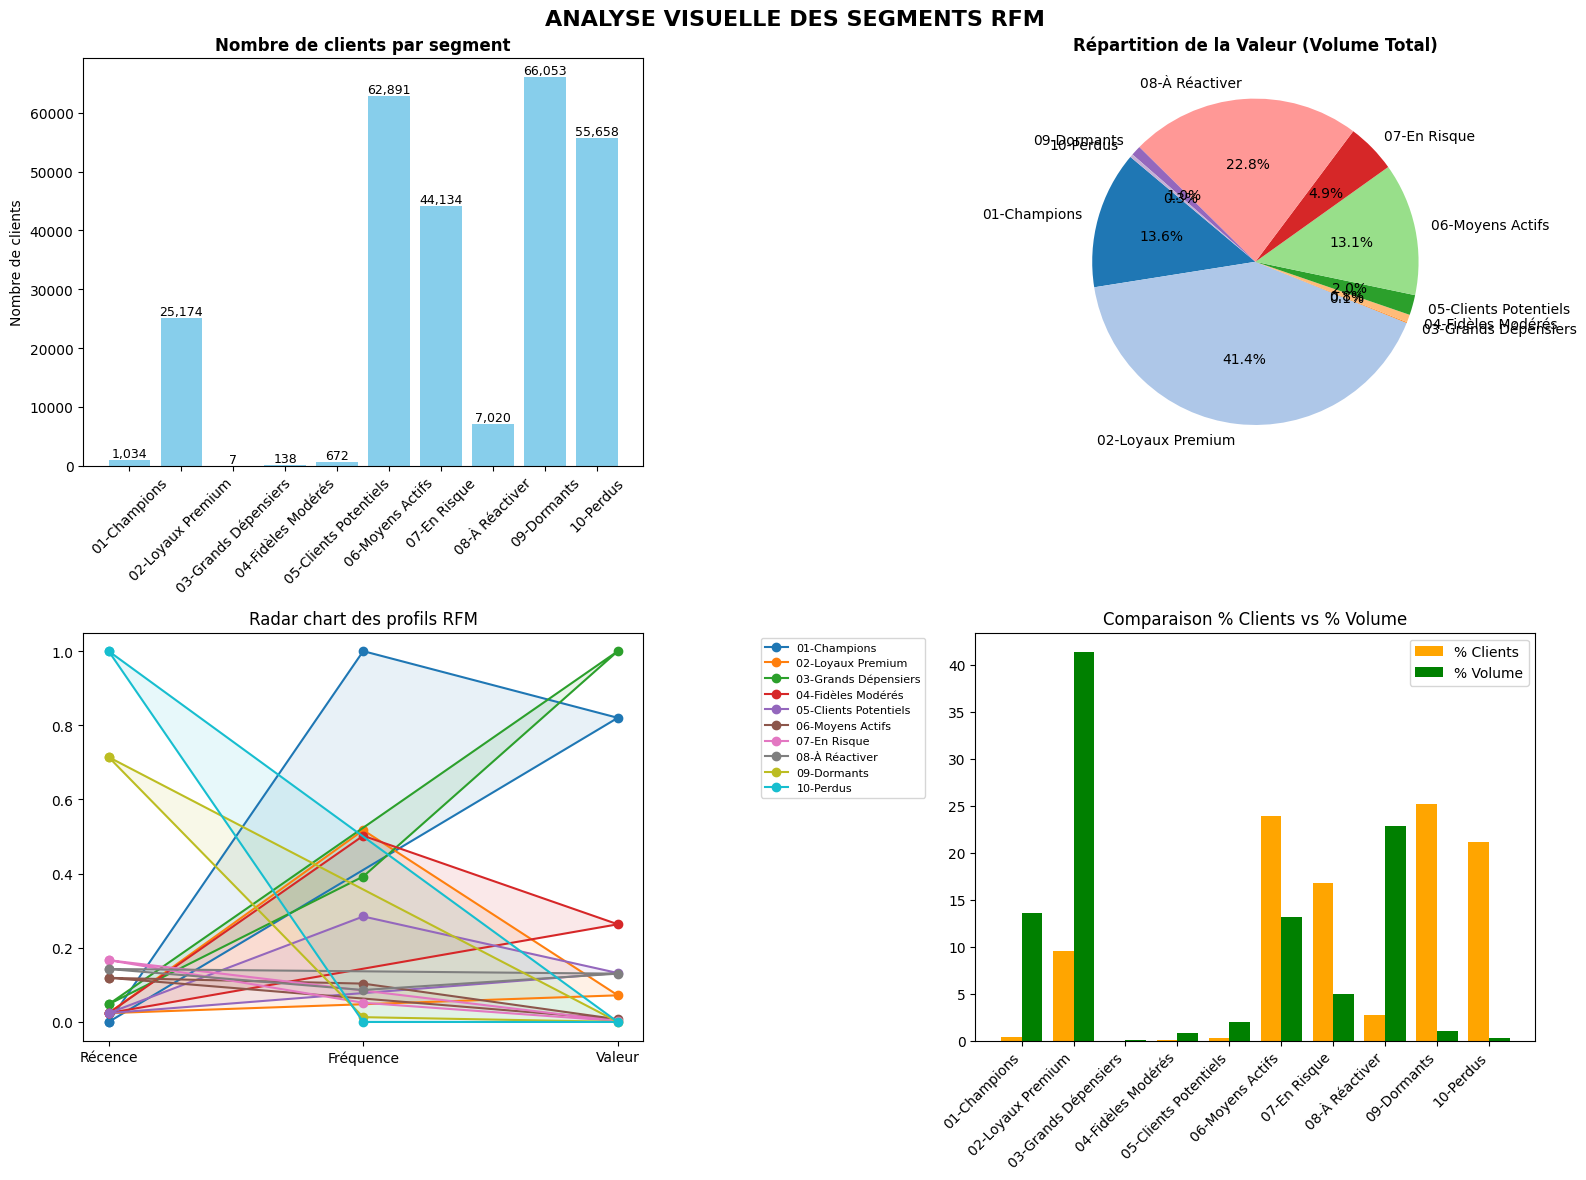

,cluster_name,nb_clients,pct_client,pct_volume,recency_mean,frequency_mean,monetary_mean
0,01-Champions,"1,034",0.4%,13.6%,1.7,319.9,"33,433,296"
1,02-Loyaux Premium,"25,174",9.6%,41.4%,2.2,155.1,"4,175,428"
2,03-Grands Dépensiers,7,0.0%,0.1%,2.9,93.3,"30,859,004"
3,04-Fidèles Modérés,138,0.1%,0.8%,3.3,161.1,"14,061,630"
4,05-Clients Potentiels,672,0.3%,2.0%,5.6,111.9,"7,528,148"
5,06-Moyens Actifs,"62,891",23.9%,13.1%,8.1,31.1,"530,749"
6,07-En Risque,"44,134",16.8%,4.9%,12.8,19.8,"282,228"
7,08-À Réactiver,"7,020",2.7%,22.8%,14.2,35.4,"8,257,913"
8,09-Dormants,"66,053",25.1%,1.0%,36.3,6.6,"38,030"
9,10-Perdus,"55,658",21.2%,0.3%,43.6,3.4,"14,103"


In [ ]:
import pandas as pd

# --- Profils détaillés pour les 10 segments RFM Djamo ---
segment_profiles = {
    '01-Champions': {
        'profil': 'Clients très récents et très dépensiers, multi-produits',
        'recency': 'Très faible (0-1 jours)',
        'valeur': 'Très élevée',
        'potentiel': 'Maintien et cross-selling'
    },
    '02-Loyaux Premium': {
        'profil': 'Fidèles, transactions régulières, actifs sur plusieurs produits',
        'recency': 'fible (1-8 jours)',
        'valeur': 'Élevée',
        'potentiel': 'Upselling et fidélisation'
    },
    '03-Grands Dépensiers': {
        'profil': 'Volume élevé mais activité irrégulière',
        'recency': 'Variable',
        'valeur': 'Élevée',
        'potentiel': 'Optimisation de la fréquence'
    },
    '04-Fidèles Modérés': {
        'profil': 'Transactions régulières, volume moyen',
        'recency': 'Faible à moyenne (10-30 jours)',
        'valeur': 'Moyenne',
        'potentiel': 'Rétention et cross-selling'
    },
    '05-Clients Potentiels': {
        'profil': 'clients avec potentiel d’augmentation du volume',
        'recency': 'Très faible (<6 jours)',
        'valeur': 'Faible mais croissante',
        'potentiel': 'Conversion vers segments supérieurs'
    },
    '06-Moyens Actifs': {
        'profil': 'Activité moyenne, multi-produits limitée',
        'recency': 'Moyenne',
        'valeur': 'Moyenne',
        'potentiel': 'Fidélisation'
    },
    '07-En Risque': {
        'profil': 'Anciennement actifs, engagement décroissant',
        'recency': 'Moyenne à élevée (15-45 jours)',
        'valeur': 'En déclin',
        'potentiel': 'Rétention urgente'
    },
    '08-À Réactiver': {
        'profil': 'Clients peu actifs, faible fréquence récente',
        'recency': 'Élevée (30-60 jours)',
        'valeur': 'Faible',
        'potentiel': 'Reactivation possible'
    },
    '09-Dormants': {
        'profil': 'Inactifs depuis longtemps, faible engagement',
        'recency': 'Très élevée (>60 jours)',
        'valeur': 'Très faible',
        'potentiel': 'Réactivation difficile'
    },
    '10-Perdus': {
        'profil': 'Clients inactifs, faible volume et fréquence',
        'recency': 'Extrêmement élevée',
        'valeur': 'Minime',
        'potentiel': 'Probablement irréversible'
    }
}

# Création du DataFrame stylisé
segment_df = pd.DataFrame.from_dict(segment_profiles, orient='index')

def color_cells(val):
    if 'Faible' in str(val) or 'Minime' in str(val) or 'difficile' in str(val) or 'déclin' in str(val):
        return 'background-color: #e6b8b8; color: #8b0000; font-weight: bold;'
    elif 'Moyenne' in str(val) or 'stable' in str(val) or 'Prévisible' in str(val):
        return 'background-color: #e6d6b8; color: #7d6608; font-weight: bold;'
    elif 'Élevée' in str(val) or 'Très élevée' in str(val) or 'croissante' in str(val):
        return 'background-color: #c8e6c9; color: #2e7d32; font-weight: bold;'
    elif 'Exceptionnelle' in str(val) or 'ultra-premium' in str(val):
        return 'background-color: #bbdefb; color: #1565c0; font-weight: bold;'
    else:
        return 'background-color: #f5f5f5; color: #424242;'

# Affichage du tableau stylisé
styled_table = segment_df.style \
    .applymap(color_cells) \
    .set_properties(**{
        'border': '2px solid #616161',
        'padding': '10px',
        'text-align': 'left',
        'font-family': 'Arial, sans-serif',
        'font-size': '12px'
    }) \
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', '#37474f'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('padding', '12px'),
            ('text-align', 'center'),
            ('border', '2px solid #455a64'),
            ('font-size', '13px'),
            ('text-transform', 'uppercase')
        ]
    }, {
        'selector': 'tr:hover',
        'props': [('background-color', '#cfd8dc')]
    }]) \
    .set_caption('🎯 SEGMENTS RFM DJAMO - PROFILS DÉTAILLÉS')

display(styled_table)

# --- Statistiques clés par segment à partir de df ---
segment_analysis = df.groupby('cluster_name').agg(
    recency_mean=('days_since_last_transaction', 'mean'),
    recency_median=('days_since_last_transaction', 'median'),
    frequency_mean=('txn_count_90d', 'mean'),
    frequency_median=('txn_count_90d', 'median'),
    monetary_mean=('total_txn_volume_90d', 'mean'),
    monetary_median=('total_txn_volume_90d', 'median'),
    n_clients=('clientid', 'count')
).reset_index()

segment_analysis['pct_client'] = 100 * segment_analysis['n_clients'] / segment_analysis['n_clients'].sum()

# Affichage
segment_analysis.sort_values('recency_mean').style.background_gradient(cmap='YlGnBu')
import matplotlib.pyplot as plt
import numpy as np

# --- Calcul du pourcentage de volume ---
cluster_summary['pct_volume'] = cluster_summary['monetary_mean'] * cluster_summary['nb_clients']
cluster_summary['pct_volume'] = 100 * cluster_summary['pct_volume'] / cluster_summary['pct_volume'].sum()

# --- Ordre des segments ---
segment_order = cluster_summary['cluster_name'].tolist()

# --- Visualisations ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ANALYSE VISUELLE DES SEGMENTS RFM', fontsize=16, fontweight='bold')

# 1️ Bar chart du nombre de clients
bars = axes[0, 0].bar(cluster_summary['cluster_name'], cluster_summary['nb_clients'], color='skyblue')
axes[0, 0].set_title("Nombre de clients par segment", fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel("Nombre de clients")
axes[0, 0].tick_params(axis="x", rotation=45)
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 2️ Pie chart de la valeur totale par segment
axes[0, 1].pie(cluster_summary['pct_volume'], labels=cluster_summary['cluster_name'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
axes[0, 1].set_title('Répartition de la Valeur (Volume Total)', fontsize=12, fontweight='bold')

# 3️ Radar chart normalisé RFM
rfm_agg = cluster_summary.set_index('cluster_name')[['recency_median','frequency_median','monetary_median']]
rfm_norm = rfm_agg.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
angles = np.linspace(0, 2*np.pi, len(rfm_norm.columns), endpoint=False).tolist()
angles += angles[:1]

for seg in rfm_norm.index:
    vals = rfm_norm.loc[seg].tolist()
    vals += vals[:1]
    axes[1, 0].plot(angles, vals, 'o-', label=seg)
    axes[1, 0].fill(angles, vals, alpha=0.1)

axes[1, 0].set_xticks(angles[:-1])
axes[1, 0].set_xticklabels(['Récence','Fréquence','Valeur'])
axes[1, 0].set_title("Radar chart des profils RFM")
axes[1, 0].legend(bbox_to_anchor=(1.2,1), fontsize=8)

# 3️ % Clients vs % Volume
x = np.arange(len(cluster_summary))
axes[1, 1].bar(x - 0.2, cluster_summary['pct_client'], width=0.4, label='% Clients', color='orange')
axes[1, 1].bar(x + 0.2, cluster_summary['pct_volume'], width=0.4, label='% Volume', color='green')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(segment_order, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].set_title("Comparaison % Clients vs % Volume")

plt.tight_layout()
plt.show()


# --- Tableau statistique clé ---
key_stats = cluster_summary[['cluster_name','nb_clients','pct_client','pct_volume','recency_mean','frequency_mean','monetary_mean']].copy()
display(key_stats.style.background_gradient(subset=['pct_client','pct_volume'], cmap='YlOrRd').format({
    'nb_clients':'{:,}',
    'pct_client':'{:.1f}%',
    'pct_volume':'{:.1f}%',
    'recency_mean':'{:.1f}',
    'frequency_mean':'{:.1f}',
    'monetary_mean':'{:,.0f}'
}))


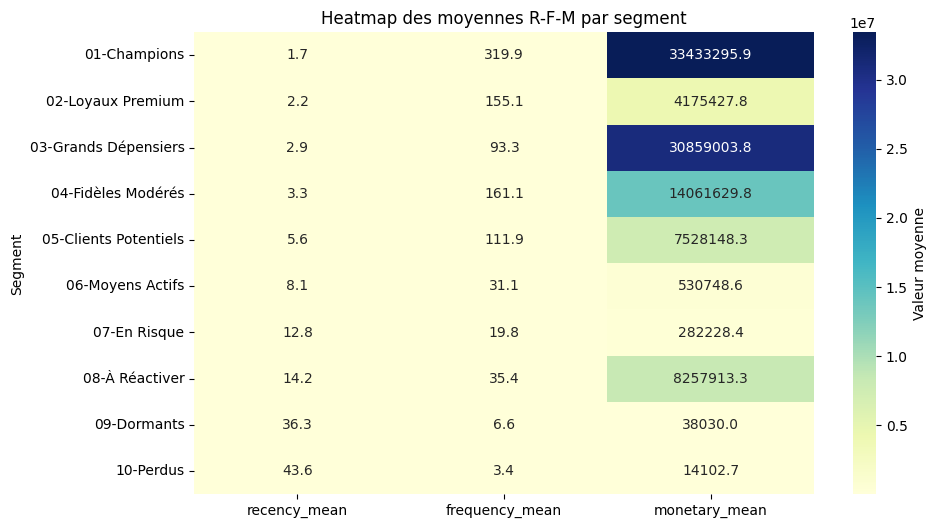

In [ ]:
# --- Préparer les données pour le heatmap ---
heatmap_data = cluster_summary.set_index('cluster_name')[
    ['recency_mean', 'frequency_mean', 'monetary_mean']
].loc[segment_order]

# Conversion explicite en float
heatmap_data = heatmap_data.astype(float)

# --- Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label':'Valeur moyenne'}
)
plt.title("Heatmap des moyennes R-F-M par segment")
plt.ylabel("Segment")
plt.show()